In [0]:
!nvidia-smi

Wed Dec  4 21:34:38 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from argparse import Namespace
import os
import json
import string
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook, tqdm
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Vocabulary and Vectorizer

In [0]:
class TextVocabulary(object):
    def __init__(self, word_to_idx = None):
        if word_to_idx:
            self.word_to_idx = word_to_idx
        else:
            self.word_to_idx = {}
        self.idx_to_word = {}

        self.unk = "<UNK>"
        self.begin = "<BEGIN>"
        self.end = "<END>"
        self.mask = "<MASK>"
        self.sep = "<SEP>"
        self.unk_idx = self.add_word(self.unk)
        self.begin_idx = self.add_word(self.begin)
        self.end_idx = self.add_word(self.end)
        self.mask_idx = self.add_word(self.mask)
        self.sep_idx = self.add_word(self.sep)
    
    def add_word(self, word):
        if word not in self.word_to_idx:
            idx = len(self.word_to_idx)
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
        return self.word_to_idx[word]
    
    def get_idx_of_word(self, word):
        return self.word_to_idx.get(word, self.unk_idx)
    
    def get_word_of_idx(self, idx):
        return self.idx_to_word[idx]
    
    def __str__(self):
        return "Vocabulary of size" + len(self.word_to_idx)
    
    def __len__(self):
        return len(self.word_to_idx)

In [0]:
class LabelVocabulary(object):
    def __init__(self, word_to_idx = None):
        if word_to_idx:
            self.word_to_idx = word_to_idx
        else:
            self.word_to_idx = {}
        self.idx_to_word = {}
    
    def add_word(self, word):
        if word not in self.word_to_idx:
            idx = len(self.word_to_idx)
            self.word_to_idx[word] = idx
            self.idx_to_word[idx] = word
        return self.word_to_idx[word]
    
    def get_idx_of_word(self, word):
        return self.word_to_idx[word]
    
    def get_word_of_idx(self, idx):
        return self.idx_to_word[idx]
    
    def __str__(self):
        return "Vocabulary of size" + len(self.word_to_idx)
    
    def __len__(self):
        return len(self.word_to_idx)

In [0]:
from nltk.tokenize import WordPunctTokenizer
class Vectorizer(object):
    def __init__(self, word_vocab, category_vocab, max_input_length):
        self.word_vocab = word_vocab
        self.category_vocab = category_vocab
        self.max_input_length = max_input_length
    
    def vectorize(self, sentence):
        idxs = np.zeros(self.max_input_length, dtype = np.int64)
        # idxs[:(len(sentence) + 2)] = [self.word_vocab.begin_idx] + [self.word_vocab.get_idx_of_word(word) for word in sentence] + [self.word_vocab.end_idx]
        idxs[:(len(sentence) + 2)] = [self.word_vocab.begin_idx] + [self.word_vocab.get_idx_of_word(word) if word in embed1 else self.word_vocab.unk_idx for word in sentence] + [self.word_vocab.end_idx]
        idxs[(len(sentence) + 2):] = self.word_vocab.mask_idx

        return idxs
    
    def reverse_vectorize(self, sentence, length):
        return [self.word_vocab.get_word_of_idx(word) for word in sentence[:length]]
    
    @classmethod
    def from_df(cls, df):
        word_vocab = TextVocabulary()
        category_vocab = LabelVocabulary()
        text_data = []
        max_input_length = -1
        for i, row in tqdm(df.iterrows(),position=0, leave=True):
            if len(row.comment) > 0:
                tmp_sent = WordPunctTokenizer().tokenize(row.comment)
                tmp_context = WordPunctTokenizer().tokenize(row.parent_comment)
                new_sent = []
                new_context = []
                if len(tmp_sent) >= 5 and len(tmp_sent) < 128 and len(tmp_context) >= 5 and len(tmp_context) < 128:
                    for word in tmp_sent:
                        tmp_word = word.lower()
                        # if len(tmp_word) > 1:
                        #     tmp_word = tmp_word.translate(str.maketrans(dict.fromkeys(string.punctuation)) )
                        word_vocab.add_word(tmp_word)
                        new_sent.append(tmp_word)
                    for word in tmp_context:
                        tmp_word = word.lower()
                        word_vocab.add_word(tmp_word)
                        new_context.append(tmp_word)
                    category_vocab.add_word(row.label)
                    text_data.append((new_sent, row.label, row, new_context))
                    if len(tmp_sent) > max_input_length:
                        max_input_length = len(tmp_sent)
                    if len(tmp_context) > max_input_length:
                        max_input_length = len(tmp_context)
        max_input_length += 2
        return cls(word_vocab, category_vocab, max_input_length), text_data
    
    @classmethod
    def from_js(cls, js):
        text_data = []
        max_input_length = -1
        word_vocab = TextVocabulary()
        category_vocab = LabelVocabulary()
        for train_data in js:
            tmp_sent = train_data["word"]
            if len(tmp_sent) >= 5 and len(tmp_sent) < 128:
                for word in tmp_sent:
                    word_vocab.add_word(word)
                category_vocab.add_word(train_data['label'])
                text_data.append((tmp_sent, int(train_data['label'])))
                if len(tmp_sent) > max_input_length:
                    max_input_length = len(tmp_sent)
        max_input_length += 2
        return cls(word_vocab, category_vocab, max_input_length), text_data

# Dataset and Dataloader

In [0]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, text_data, vectorizer):
        self.text_data = text_data
        self.vectorizer = vectorizer
        self.vec_data = []
        for data in text_data:
            text = self.vectorizer.vectorize(data[0])
            context = self.vectorizer.vectorize(data[3])
            label = self.vectorizer.category_vocab.get_idx_of_word(data[1])
            self.vec_data.append((text, label, len(data[0]) + 2, data[2], len(self.vec_data), context, len(data[3]) + 2))
        
    def __len__(self):
        return len(self.text_data)
    
    def __getitem__(self, index):
        text, label, length, row, pk, context, context_length = self.vec_data[index]
        return {
            "input":torch.tensor(text),
            "output":torch.tensor(label),
            "input_length":length,
            "pk":pk,
            "context":torch.tensor(context),
            "context_length":context_length,
            # "row":row,
        }
        # return torch.tensor(text).to(device), torch.tensor(label).to(device),

In [0]:
def custom_batch_generator(dataset, batch_size, shuffle, num_workers, device):
    dataloader = DataLoader(dataset, batch_size = batch_size, shuffle = shuffle, num_workers = num_workers)
    for data in dataloader:
        input_lengths = data['input_length'].numpy()
        input_lengths_sorted_indices = input_lengths.argsort()[::-1].tolist()
        output_data = {}
        for key, value in data.items():
            output_data[key] = data[key][input_lengths_sorted_indices].to(device)
        yield output_data

# Load Glove 200d

Glove

In [0]:
import numpy as np
glove = {}
with open('/content/drive/My Drive/glove.6B/glove.6B.200d.txt', 'rb') as f:
    lines = f.readlines()
    for i in range(len(lines)):
        line = lines[i].decode().split()
        glove[line[0]] = np.array(line[1:]).astype(np.float)

Twitter

In [0]:
embed1 = dict()
with open('/content/drive/My Drive/word2vec_twitter_tokens.bin', 'rb') as f: 
    header = f.readline()
    vocab_size, layer1_size = map(int, header.split())
    binary_len = np.dtype('float32').itemsize * layer1_size
    for line in tqdm(range(vocab_size), position=0, leave=True):
        word = []
        while True:
            ch = f.read(1).decode(errors='ignore')
            if ch ==' ':
                word = ''.join(word)
                break
            if ch != '\n':
                word.append(ch)
        if len(word) != 0 and word in vectorizer_train.word_vocab.word_to_idx:
            tp= np.fromstring(f.read(binary_len), dtype='float32')
            embed1[str(word)]=tp.tolist()
        else:
            f.read(binary_len)

  0%|          | 0/3039345 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  app.launch_new_instance()
100%|██████████| 3039345/3039345 [00:54<00:00, 56001.06it/s] 


Create dataset(either from reddit-sarcasm or task3)

# Create Dataset

Read data from reddit-sarcasm.csv

In [0]:
data_csv = pd.read_csv('/content/drive/My Drive/train-balanced-sarcasm.csv')
data_csv.comment = data_csv.comment.astype(str)
data_csv_shuffled = data_csv.sample(frac=1)

In [0]:
tmp_dict = {}
for i, row in tqdm(data_csv_shuffled.iterrows(),position=0, leave=True):
    if len(row.comment) > 0:
        tmp_sent = WordPunctTokenizer().tokenize(row.comment)
        if len(tmp_sent) not in tmp_dict:
            tmp_dict[len(tmp_sent)] = 0
        tmp_dict[len(tmp_sent)] += 1
print(tmp_dict)

1010826it [03:12, 5264.21it/s]

{9: 59629, 2: 37570, 6: 58726, 3: 45654, 11: 52609, 10: 55957, 15: 36935, 7: 60367, 5: 54108, 8: 60783, 12: 49205, 20: 20605, 18: 26333, 40: 1568, 1: 20063, 28: 7425, 35: 2881, 13: 44947, 4: 46496, 17: 29801, 19: 23264, 23: 14043, 31: 4962, 16: 33130, 29: 6464, 32: 4282, 14: 40982, 34: 3420, 21: 18165, 24: 12502, 22: 16143, 25: 10606, 60: 215, 63: 156, 27: 8436, 48: 658, 26: 9643, 37: 2313, 30: 5641, 38: 1982, 45: 862, 56: 283, 42: 1288, 36: 2639, 39: 1775, 53: 364, 41: 1438, 46: 860, 57: 274, 33: 3788, 50: 565, 49: 597, 82: 35, 43: 1084, 55: 334, 106: 16, 44: 1047, 47: 707, 67: 126, 61: 167, 54: 362, 69: 85, 62: 164, 104: 11, 77: 54, 89: 24, 75: 58, 51: 446, 642: 1, 52: 449, 83: 25, 58: 244, 79: 51, 239: 1, 72: 88, 64: 149, 572: 1, 78: 48, 123: 3, 101: 9, 65: 137, 59: 245, 163: 3, 94: 24, 71: 81, 118: 4, 105: 6, 800: 1, 102: 17, 119: 6, 66: 122, 109: 11, 68: 81, 70: 82, 137: 4, 95: 10, 115: 7, 84: 23, 92: 21, 540: 1, 74: 57, 112: 9, 73: 65, 81: 45, 86: 22, 80: 56, 88: 24, 116: 3, 90: 

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]


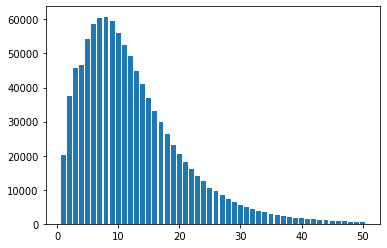

In [0]:
import matplotlib.pyplot as plt
import collections
od = collections.OrderedDict(sorted(tmp_dict.items()))
odd = []
odd2 = []
for i, (k,v) in enumerate(od.items()):
    if i < 50:
        if k == (i + 1):
            odd.append(k)
            odd2.append(v)
        else:
            odd.append(i + 1)
            odd2.append(0)
print(odd)
plt.bar(odd, odd2)
plt.show()

In [0]:
data_csv_shuffled

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
622063,0,"""Hulu and fuck?""",elj0h0,AskReddit,3,3,0,2015-10,2015-10-04 20:04:51,"(After a bit of conversation)... ""Hey I think ..."
391992,0,But your dad is only 13,PastelFlamingo150,pics,1,1,0,2016-02,2016-02-24 23:31:58,My mom just sent me this photo of my dad. I'm ...
214348,1,LOW ENERGY ARTICLE,JPetermanRealityTour,hillaryclinton,3,3,0,2016-05,2016-05-01 12:28:46,"No, Liberals Are Not Being Condescending About..."
327117,1,but DAE le r/patriots2?,thebochman,nfl,-4,-4,0,2016-07,2016-07-25 20:10:20,Broncos and Colts fans perusing new comments t...
842705,1,"Cook, Serve, Delicious!",acwarren492,pcmasterrace,1,1,0,2014-08,2014-08-31 01:17:35,20 games. Pick and choose. Comment which game ...
...,...,...,...,...,...,...,...,...,...,...
782492,1,Happy to see my paranoia is never going away.,Cuin-Manari,technology,6,6,0,2015-06,2015-06-02 03:43:11,This Shadow Government Agency Is Scarier Than ...
887728,1,Just like Chara is booed because he's a Slovak...,Xtremefluff,hockey,6,6,0,2014-05,2014-05-02 04:32:04,The PK Subban booing is embarrassing
914552,1,Because.. you know.... Obama would never bomb ...,x888x,politics,-6,-6,0,2012-09,2012-09-11 16:18:23,no he's doing it because he wants us to bomb I...
635834,0,Envoy paying higher prices,schoolsbelly,texas,1,1,0,2015-12,2015-12-31 13:22:48,I'm mad at them as well. I'm shopping at Kroge...


In [0]:
vectorizer_train, text_data_train = Vectorizer.from_df(data_csv_shuffled[:60000])
vectorizer_test, text_data_test = Vectorizer.from_df(data_csv_shuffled[60000:100000])
if vectorizer_train.max_input_length < vectorizer_test.max_input_length:
    vectorizer_train.max_input_length = vectorizer_test.max_input_length

60000it [00:17, 3469.65it/s]
40000it [00:11, 3390.35it/s]


Read data from task3

In [0]:
with open('/content/drive/My Drive/task3_train 1.txt','r') as rf:
    train_task3 = rf.read()
train_task3 = json.JSONDecoder().decode(train_task3)
with open('/content/drive/My Drive/task3_test 1.txt','r') as rf:
    test_task3 = rf.read()
test_task3 = json.JSONDecoder().decode(test_task3)

In [0]:
vectorizer_train, text_data_train = Vectorizer.from_js(train_task3)
vectorizer_test, text_data_test = Vectorizer.from_js(test_task3)
if vectorizer_train.max_input_length < vectorizer_test.max_input_length:
    vectorizer_train.max_input_length = vectorizer_test.max_input_length

Create Embedding Matrix and Datasets

In [0]:
weights_mat = np.zeros((len(vectorizer_train.word_vocab), 400))
counter = 0
not_counter = 0
print_counter = 0
for word, index in vectorizer_train.word_vocab.word_to_idx.items():
    if word in embed1:
        counter += 1
        weights_mat[index] = embed1[word]
    else:
        print_counter += 1
        if  200 < print_counter < 220:
            print("word:",word,"not found")
        not_counter += 1
        weights_mat[index] = np.random.normal(scale = 0.6, size=(400,))
        
print("found:",counter,"not found:",not_counter)

word: 5th not found
word: emeralddragoness not found
word: xxxx420_n0_sc0p3_l0n3_w0lfxxxx not found
word: imdia not found
word: munitv not found
word: tkj not found
word: 238 not found
word: 2008 not found
word: .). not found
word: 68th not found
word: 58th not found
word: 59th not found
word: dellavadova not found
word: amiriteguys not found
word: 91 not found
word: 85 not found
word: f3 not found
word: 18 not found
word: 1957 not found
found: 46534 not found: 9647


In [0]:
train_set = Dataset(text_data_train, vectorizer_train)
test_set = Dataset(text_data_test, vectorizer_train)

In [0]:
tmp_data = train_set[1113]
# print(tmp_data['row'])
print(vectorizer_train.reverse_vectorize(tmp_data['input'].numpy(), tmp_data['input_length']), tmp_data['pk'])

['<BEGIN>', 'but', 'i', 'thought', 'all', 'dichotomies', 'are', 'false', 'dichotomies', '!', '<END>'] 1113


# Model Definition

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class GRUClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, gru_hidden_size, bidirectional, num_layers, batch_first, num_classes, dropout):
        super().__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.FloatTensor(weights_mat), freeze=True)
        self.gru = nn.GRU(input_size = embedding_dim, num_layers = num_layers, bidirectional=bidirectional, hidden_size = gru_hidden_size, batch_first = batch_first)
        self.fc = nn.Linear(gru_hidden_size * 2 if bidirectional else gru_hidden_size , num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed = pack_padded_sequence(embedded, text_lengths.detach().cpu().numpy(), batch_first=True)
        gru_packed_output, gru_hidden = self.gru(packed)
        # gru_out, gru_out_lengths = pad_packed_sequence(gru_packed_output, batch_first = True)
        if self.gru.bidirectional:
            gru_hidden = self.dropout(torch.cat((gru_hidden[-2,:,:], gru_hidden[-1,:,:]), dim = 1))
        else:
            gru_hidden = self.dropout(gru_hidden[-1,:,:])
        # gru_out = gru_out.permute(1, 0, 2) #batch_size, seq_len, num_direction*hidden_size
        # gru_hidden = gru_hidden.permute(1, 0, 2) #batch_size, num_layers*direction, hidden_sizes

        return self.fc(gru_hidden)

In [0]:
class CNN_LSTM_forward(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, hidden_dim, filter_size, output_dim, dropout, max_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.FloatTensor(weights_mat), freeze=True)
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = num_filters, padding=(filter_size // 2, 0),  
                               kernel_size = (filter_size, embedding_dim))
        self.conv2 = nn.Conv1d(in_channels = num_filters, out_channels = num_filters, padding=filter_size // 2, 
                               kernel_size = filter_size)
        self.lstm = nn.LSTM(num_filters, hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Linear(max_length * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self, text, text_lengths = None):
        embedded = self.embedding(text)
        c1 = self.conv1(embedded.unsqueeze(1))
        c1 = c1.squeeze(3)
        c2 = self.conv2(c1)
        c2 = c2.transpose(1, 2)
        o, (h, c) = self.lstm(c2)
        o = self.dropout(o)
        return self.fc(o.contiguous().view(o.size(0), -1))

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class LSTM2LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, gru_hidden_size, bidirectional, num_layers, batch_first, num_classes, dropout):
        super().__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding1 = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.FloatTensor(weights_mat), freeze=True)
        self.gru1 = nn.GRU(input_size = embedding_dim, num_layers = num_layers, bidirectional=bidirectional, hidden_size = gru_hidden_size, batch_first = batch_first)
        
        self.embedding2 = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.FloatTensor(weights_mat), freeze=True)
        self.gru2 = nn.GRU(input_size = embedding_dim, num_layers = num_layers, bidirectional=bidirectional, hidden_size = gru_hidden_size, batch_first = batch_first)
        self.fc = nn.Linear(gru_hidden_size * 2 if bidirectional else gru_hidden_size , num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths, context, context_lengths):
        embedded1= self.embedding1(context)
        packed1 = pack_padded_sequence(embedded1, context_lengths.detach().cpu().numpy(), batch_first=True, enforce_sorted=False)
        gru_packed_output1, gru_hidden1 = self.gru1(packed1)

        embedded2 = self.embedding2(text)
        packed2 = pack_padded_sequence(embedded2, text_lengths.detach().cpu().numpy(), batch_first=True, enforce_sorted=False)

        gru_packed_output2, gru_hidden2 = self.gru2(packed2, gru_hidden1)
        # gru_out, gru_out_lengths = pad_packed_sequence(gru_packed_output, batch_first = True)
        if self.gru2.bidirectional:
            gru_hidden2 = self.dropout(torch.cat((gru_hidden2[-2,:,:], gru_hidden2[-1,:,:]), dim = 1))
        else:
            gru_hidden2 = self.dropout(gru_hidden2[-1,:,:])
        # gru_out = gru_out.permute(1, 0, 2) #batch_size, seq_len, num_direction*hidden_size
        # gru_hidden = gru_hidden.permute(1, 0, 2) #batch_size, num_layers*direction, hidden_sizes

        return self.fc(gru_hidden2)

In [0]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.FloatTensor(weights_mat), freeze=True)
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = num_filters, 
                                              kernel_size = (filter_size, embedding_dim)) for filter_size in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.embedding.weight.data[vectorizer_train.word_vocab.mask_idx] = torch.zeros(embedding_dim)
        self.embedding.weight.data[vectorizer_train.word_vocab.unk_idx] = torch.zeros(embedding_dim)
        
    def forward(self, text, text_lengths = None):
        embedded = self.embedding(text).unsqueeze(1)
        # print("embedded", embedded.size())
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # print("conved(different kernels)", conved[0].size(), conved[1].size())
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]     
        # print("polled(different kernels)", pooled[0].size(), pooled[1].size())
        cat = self.dropout(torch.cat(pooled, dim = 1))
        # print("cat", cat.size())
        return self.fc(cat)

In [0]:
class CNN_LSTM_Concat(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters, filter_sizes, output_dim, dropout, gru_hidden_size, bidirectional, num_layers, batch_first):
        super().__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.FloatTensor(weights_mat), freeze=True)
        self.gru = nn.GRU(input_size = embedding_dim, num_layers = num_layers, bidirectional=bidirectional, hidden_size = gru_hidden_size, batch_first = batch_first)
        
        self.convs = nn.ModuleList([nn.Conv2d(in_channels = 1, 
                                              out_channels = num_filters, 
                                              kernel_size = (filter_size, embedding_dim)) for filter_size in filter_sizes])

        self.dropout = nn.Dropout(dropout)
        # self.embedding.weight.data[vectorizer_train.word_vocab.mask_idx] = torch.zeros(embedding_dim)
        # self.embedding.weight.data[vectorizer_train.word_vocab.unk_idx] = torch.zeros(embedding_dim)
        
        cnn_gru_dim = len(filter_sizes) * num_filters + gru_hidden_size * 2 if bidirectional else gru_hidden_size
        self.fc1 = nn.Linear(cnn_gru_dim, cnn_gru_dim // 2)
        self.fc2 = nn.Linear(cnn_gru_dim // 2, output_dim)
        
    def forward(self, text, text_lengths = None):

        embedded = self.embedding(text)
        embedded_unsqueeze = self.embedding(text).unsqueeze(1)

        packed = pack_padded_sequence(embedded, text_lengths.detach().cpu().numpy(), batch_first=True)
        gru_packed_output, gru_hidden = self.gru(packed)
        # gru_out, gru_out_lengths = pad_packed_sequence(gru_packed_output, batch_first = True)
        if self.gru.bidirectional:
            gru_hidden = self.dropout(torch.cat((gru_hidden[-2,:,:], gru_hidden[-1,:,:]), dim = 1))
        else:
            gru_hidden = self.dropout(gru_hidden[-1,:,:])

        conved = [F.relu(conv(embedded_unsqueeze)).squeeze(3) for conv in self.convs]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]     
        cat = self.dropout(torch.cat(pooled, dim = 1))

        cnn_lstm = self.dropout(torch.cat((cat, gru_hidden), dim = 1))
        hidden2hidden = self.dropout(self.fc1(cnn_lstm))
        return self.fc2(hidden2hidden)

In [0]:
import torch.nn as nn
import torch.nn.functional as F
class GRUPoolClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, gru_hidden_size, bidirectional, num_layers, batch_first, num_classes, dropout):
        super().__init__()
        # self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding = nn.Embedding(vocab_size, embedding_dim).from_pretrained(torch.FloatTensor(weights_mat), freeze=True)
        self.gru = nn.GRU(input_size = embedding_dim, num_layers = num_layers, bidirectional=bidirectional, hidden_size = gru_hidden_size, batch_first = batch_first)
        self.fc = nn.Linear(gru_hidden_size * 2 if bidirectional else gru_hidden_size * 2 , num_classes)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed = pack_padded_sequence(embedded, text_lengths.detach().cpu().numpy(), batch_first=True)
        gru_packed_output, gru_hidden = self.gru(packed)
        gru_out, gru_out_lengths = pad_packed_sequence(gru_packed_output, batch_first = True)

        # print("before, gru out:", gru_out.shape)
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(0,2,1),1).squeeze(2)  # .view(text.size(0), -1)
        # print("after, avg_pool:", avg_pool.shape)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1),1).squeeze(2)  # .view(text.size(0), -1)

        return self.fc(self.dropout(torch.cat([avg_pool,max_pool],dim=1)))

# Train Functions

In [0]:
def train(classifier, criterion, optimizer, trainLoader):
    epoch_loss = 0
    epoch_correct = 0
    counter = 0
    tp = 0
    ap = 0
    fn = 0
    classifier.train()
    for i, data in enumerate(tqdm_notebook(trainLoader, position=0, leave=True)):
        counter += 1
        optimizer.zero_grad()
        predictions = classifier(data['input'], data['input_length'],data['context'], data['context_length'])
        loss = criterion(predictions, data['output'])
        _, max_labels = predictions.max(1)

        tp += (data['output'] * ((data['output'] == max_labels) == 1)).sum().item()
        ap += (max_labels == 1).sum().item()
        tn = (data['output'] * ((data['output'] == max_labels) == 0)).sum().item()
        fn += (data['output'] == 0).sum().item() - tn

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_correct += (data['output'] == max_labels).sum().item()/len(data['output'])

        recall = tp / (tp + fn)
        precision = tp / ap
      
    return epoch_loss / counter, epoch_correct / counter, 2 * (precision * recall) / (precision + recall) , recall, precision

def evaluate(classifier, criterion, optimizer, validLoader):
    epoch_loss = 0
    epoch_correct = 0
    counter = 0
    correct_counter = 0
    tp = 0
    ap = 0
    fn = 0
    classifier.eval()
    correct_idxs = np.zeros(len(test_set))
    with torch.no_grad():
        for i, data in enumerate(tqdm_notebook(validLoader, position=0, leave=True)):
            counter += 1
            predictions = classifier(data['input'], data['input_length'], data['context'], data['context_length'])
            
            loss = criterion(predictions, data['output'])
            _, max_labels = predictions.max(1)

            tp += (data['output'] * ((data['output'] == max_labels) == 1)).sum().item()
            ap += (max_labels == 1).sum().item()
            tn = (data['output'] * ((data['output'] == max_labels) == 0)).sum().item()
            fn += (data['output'] == 0).sum().item() - tn

            tmp_idxs = (data['output'] == max_labels)
            tmp_idxs_sum = tmp_idxs.sum().item()

            epoch_correct += tmp_idxs_sum/len(data['output'])
            epoch_loss += loss.item()

            correct_idxs[correct_counter:correct_counter + tmp_idxs_sum] = data['pk'][tmp_idxs].detach().cpu().numpy()
            correct_counter += tmp_idxs_sum
    correct_idxs = correct_idxs[:correct_counter]
    recall = tp / (tp + fn)
    precision = tp / ap
    return epoch_loss / counter, epoch_correct / counter, correct_idxs, 2 * (precision * recall) / (precision + recall) , recall, precision

In [0]:
import time
def train_model(classifier, criterion, optimizer, 
                trainSet, testSet, n_epochs = 10):
    params = {  
        'batch_size':128,
        'shuffle':True,
        'num_workers':0,
        'device':device,
    }
    train_ls_acc, valid_ls_acc = [], []
    for epoch in range(n_epochs):
        train_loader = custom_batch_generator(trainSet, **params)
        test_loader = custom_batch_generator(testSet, **params)

        start_time = time.time()

        train_loss, train_acc, train_f1, train_recall, train_precision = train(classifier, criterion, optimizer, train_loader)
        valid_loss, valid_acc, correct_idxs, valid_f1, valid_recall, valid_precision = evaluate(classifier, criterion, optimizer, test_loader)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        epoch_mins = int(elapsed_time/60)
        epoch_secs = int(elapsed_time - epoch_mins*60)
        
        train_ls_acc.append((train_loss, train_acc))
        valid_ls_acc.append((valid_loss, valid_acc))
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train F1 score: {train_f1:.2f}% |Train Recall score: {train_recall:.2f}% |  Train Precision score: {train_precision:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}% | Valid F1 score: {valid_f1:.2f}% |Valid Recall score: {valid_recall:.2f}% |  Valid Precision score: {valid_precision:.2f}%')
    return train_ls_acc, valid_ls_acc, correct_idxs

# Train Section

In [0]:
import torch.optim as optim
torch.multiprocessing.set_start_method('spawn', force=True)

In [0]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [0]:
params = {
    "vocab_size":len(vectorizer_train.word_vocab),
    "embedding_dim":400,
    "gru_hidden_size":256,
    "num_classes":2,
    "batch_first":True,
    "dropout":0.5,
    "bidirectional":True,
    "num_layers":3,
}
model_gru = GRUClassifier(**params).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_gru.parameters())
print(f'The model has {count_parameters(model_gru):,} trainable parameters')

The model has 3,377,154 trainable parameters


In [0]:
train_acc, valid_acc, gru_correct_idxs = train_model(model_gru, criterion, optimizer, train_set, test_set, n_epochs = 6)


Epoch: 01 | Epoch Time: 5m 36s
	Train Loss: 0.576 | Train Acc: 69.31%
	 Val. Loss: 0.549 |  Val. Acc: 71.84%



Epoch: 02 | Epoch Time: 5m 36s
	Train Loss: 0.529 | Train Acc: 73.25%
	 Val. Loss: 0.526 |  Val. Acc: 73.47%



Epoch: 03 | Epoch Time: 5m 37s
	Train Loss: 0.503 | Train Acc: 75.17%
	 Val. Loss: 0.521 |  Val. Acc: 73.93%



Epoch: 04 | Epoch Time: 5m 38s
	Train Loss: 0.476 | Train Acc: 77.01%
	 Val. Loss: 0.520 |  Val. Acc: 74.43%



Epoch: 05 | Epoch Time: 5m 36s
	Train Loss: 0.441 | Train Acc: 79.22%
	 Val. Loss: 0.535 |  Val. Acc: 74.04%



Epoch: 06 | Epoch Time: 5m 36s
	Train Loss: 0.396 | Train Acc: 81.90%
	 Val. Loss: 0.558 |  Val. Acc: 73.25%


In [0]:
print(len(gru_correct_idxs), len(test_set))

121519 170184


In [0]:
params = {
    "vocab_size":len(vectorizer_train.word_vocab),
    "embedding_dim":400,
    "gru_hidden_size":256,
    "num_classes":2,
    "batch_first":True,
    "dropout":0.5,
    "bidirectional":True,
    "num_layers":3,
}
model_lstm2lstm = LSTM2LSTMClassifier(**params).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_lstm2lstm.parameters())
print(f'The model has {count_parameters(model_lstm2lstm):,} trainable parameters')

The model has 6,753,282 trainable parameters


In [0]:
train_acc, valid_acc, grupool_correct_idxs = train_model(model_lstm2lstm, criterion, optimizer, train_set, test_set, n_epochs = 6)


Epoch: 01 | Epoch Time: 0m 41s
	Train Loss: 0.646 | Train Acc: 61.94% | Train F1 score: 0.52% |Train Recall score: 0.46% |  Train Precision score: 0.61%
	 Val. Loss: 0.608 |  Val. Acc: 66.44% | Valid F1 score: 0.54% |Valid Recall score: 0.47% |  Valid Precision score: 0.65%



Epoch: 02 | Epoch Time: 0m 41s
	Train Loss: 0.591 | Train Acc: 68.36% | Train F1 score: 0.55% |Train Recall score: 0.47% |  Train Precision score: 0.66%
	 Val. Loss: 0.596 |  Val. Acc: 67.24% | Valid F1 score: 0.54% |Valid Recall score: 0.47% |  Valid Precision score: 0.64%



Epoch: 03 | Epoch Time: 0m 40s
	Train Loss: 0.561 | Train Acc: 70.69% | Train F1 score: 0.56% |Train Recall score: 0.47% |  Train Precision score: 0.68%
	 Val. Loss: 0.598 |  Val. Acc: 67.69% | Valid F1 score: 0.54% |Valid Recall score: 0.47% |  Valid Precision score: 0.64%



Epoch: 04 | Epoch Time: 0m 41s
	Train Loss: 0.527 | Train Acc: 73.42% | Train F1 score: 0.57% |Train Recall score: 0.47% |  Train Precision score: 0.71%
	 Val. Loss: 0.602 |  Val. Acc: 67.31% | Valid F1 score: 0.55% |Valid Recall score: 0.47% |  Valid Precision score: 0.67%



Epoch: 05 | Epoch Time: 0m 41s
	Train Loss: 0.478 | Train Acc: 76.89% | Train F1 score: 0.58% |Train Recall score: 0.47% |  Train Precision score: 0.75%
	 Val. Loss: 0.659 |  Val. Acc: 66.40% | Valid F1 score: 0.54% |Valid Recall score: 0.46% |  Valid Precision score: 0.66%



Epoch: 06 | Epoch Time: 0m 41s
	Train Loss: 0.394 | Train Acc: 82.10% | Train F1 score: 0.60% |Train Recall score: 0.47% |  Train Precision score: 0.81%
	 Val. Loss: 0.759 |  Val. Acc: 66.11% | Valid F1 score: 0.54% |Valid Recall score: 0.46% |  Valid Precision score: 0.65%


In [0]:
print(len(grupool_correct_idxs), len(test_set))
intersect_gru_grupool = np.intersect1d(grupool_correct_idxs, gru_correct_idxs)
print(len(intersect_gru_grupool))

122674 170184
107513


In [0]:
params = {
    "vocab_size":len(vectorizer_train.word_vocab),
    "embedding_dim":400,
    "num_filters":256,
    "output_dim":2,
    "filter_sizes":[2,3,4,5,6,7],
    "dropout":0.5,
}
model_cnn = CNN(**params).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_cnn.parameters())
print(f'The model has {count_parameters(model_cnn):,} trainable parameters')

The model has 2,769,410 trainable parameters


In [0]:
train_acc, valid_acc, cnn_correct_idxs = train_model(model_cnn, criterion, optimizer, train_set, test_set, n_epochs = 6)


Epoch: 01 | Epoch Time: 4m 20s
	Train Loss: 0.614 | Train Acc: 65.83% | Train F1 score: 0.56% |Train Recall score: 0.50% |  Train Precision score: 0.65%
	 Val. Loss: 0.589 |  Val. Acc: 68.14% | Valid F1 score: 0.58% |Valid Recall score: 0.50% |  Valid Precision score: 0.70%



Epoch: 02 | Epoch Time: 4m 19s
	Train Loss: 0.591 | Train Acc: 68.15% | Train F1 score: 0.57% |Train Recall score: 0.50% |  Train Precision score: 0.67%
	 Val. Loss: 0.577 |  Val. Acc: 69.38% | Valid F1 score: 0.58% |Valid Recall score: 0.50% |  Valid Precision score: 0.69%



Epoch: 03 | Epoch Time: 4m 21s
	Train Loss: 0.582 | Train Acc: 68.98% | Train F1 score: 0.57% |Train Recall score: 0.50% |  Train Precision score: 0.67%
	 Val. Loss: 0.573 |  Val. Acc: 69.75% | Valid F1 score: 0.58% |Valid Recall score: 0.50% |  Valid Precision score: 0.70%



Epoch: 04 | Epoch Time: 4m 21s
	Train Loss: 0.574 | Train Acc: 69.64% | Train F1 score: 0.57% |Train Recall score: 0.50% |  Train Precision score: 0.68%
	 Val. Loss: 0.574 |  Val. Acc: 69.71% | Valid F1 score: 0.58% |Valid Recall score: 0.50% |  Valid Precision score: 0.71%



Epoch: 05 | Epoch Time: 4m 20s
	Train Loss: 0.568 | Train Acc: 70.19% | Train F1 score: 0.58% |Train Recall score: 0.50% |  Train Precision score: 0.69%
	 Val. Loss: 0.567 |  Val. Acc: 70.24% | Valid F1 score: 0.57% |Valid Recall score: 0.50% |  Valid Precision score: 0.67%



Epoch: 06 | Epoch Time: 4m 20s
	Train Loss: 0.561 | Train Acc: 70.80% | Train F1 score: 0.58% |Train Recall score: 0.50% |  Train Precision score: 0.69%
	 Val. Loss: 0.565 |  Val. Acc: 70.40% | Valid F1 score: 0.57% |Valid Recall score: 0.50% |  Valid Precision score: 0.67%


In [0]:
print(len(cnn_correct_idxs), len(test_set))
intersect_cnn_grupool_gru = np.intersect1d(np.intersect1d(cnn_correct_idxs, gru_correct_idxs), grupool_correct_idxs)
print(len(intersect_cnn_grupool_gru))

118847 170184
94854


In [0]:
wrong_idxs = []
for i in tqdm_notebook(range(len(test_set))):
    if i not in gru_correct_idxs:
        wrong_idxs.append(i)
print(len(wrong_idxs))
# vectorizer_train.reverse_vectorize(tmp_data['input'].numpy(), tmp_data['input_length'])

48665


In [0]:
for j in range(20):
    tmp_data = test_set[wrong_idxs[j]]
    print(vectorizer_train.reverse_vectorize(tmp_data['input'].numpy(), tmp_data['input_length']), "GROUND TRUTH", tmp_data['output'])

['<BEGIN>', 'ah', 'yea', ',', 'if', 'they', 'don', "'", 't', 'like', 'what', 'you', 'like', 'they', "'", 're', 'wrong', 'and', 'their', 'taste', 'in', 'music', 'is', 'shit', '.', '<END>'] GROUND TRUTH tensor(1)
['<BEGIN>', 'yeah', '...', 'but', 'having', 'to', 'delete', 'it', 'from', 'your', 'phone', 'and', 'download', 'it', 'again', 'in', 'each', 'update', 'isn', "'", 't', 'an', '<UNK>', 'to', 'casual', 'players', '<END>'] GROUND TRUTH tensor(1)
['<BEGIN>', 'maybe', 'this', 'finally', 'makes', 'people', 'realize', 'why', 'movements', 'like', '<UNK>', 'are', 'so', '<UNK>', 'needed', '.', '<END>'] GROUND TRUTH tensor(0)
['<BEGIN>', 'i', 'really', 'hope', 'this', 'was', '<END>'] GROUND TRUTH tensor(1)
['<BEGIN>', 'so', 'because', 'it', 'was', 'alright', 'for', 'you', 'means', 'it', "'", 's', 'alright', 'for', 'everybody', '?', '<END>'] GROUND TRUTH tensor(0)
['<BEGIN>', 'all', 'you', 'want', 'to', 'do', 'all', 'day', 'is', 'play', 'with', 'ten', 'year', 'old', 'boys', '?', '<END>'] GROUN

In [0]:
params = {
    "vocab_size":len(vectorizer_train.word_vocab),
    "embedding_dim":400,
    "num_filters":300,
    "output_dim":2,
    "filter_sizes":[2,3,4,5,6,7],
    "dropout":0.5,
    "gru_hidden_size":300,
    "batch_first":True,
    "bidirectional":True,
    "num_layers":3,
}
model_cnn_lstm = CNN_LSTM_Concat(**params).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model_cnn_lstm.parameters())
print(f'The model has {count_parameters(model_cnn_lstm):,} trainable parameters')

The model has 10,636,202 trainable parameters


In [0]:
train_acc, valid_acc = train_model(model_cnn_lstm
, criterion, optimizer, train_set, test_set, n_epochs = 10)